In [1]:
import random
import json
import os, sys
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer

random.seed(6)
np.random.seed(6)

hugg_auth_token = os.environ.get("HUGGINGFACE_KEY")


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# My modules

WORK_DIR = Path.cwd().parent
sys.path.append(str(WORK_DIR))

from src import (
    response_processing as rp,
    graph_gen,
    video_tools)


In [3]:
# Files
STAR_VAL_SMALL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json"
QA_SGG = WORK_DIR / "outputs/gr_understaing_on_genstg_20250628_00:26:00_val_gemma3:4b-it-qat_20250620_20:39:00.jsonl"
SGG_GRAPHS = WORK_DIR / "outputs/sgg/sgg2_1fps_batchedimages_gemma3:4b-it-qat_202500701_19:20:00.jsonl"

RAW_VIDEO_DIR = Path(WORK_DIR / 'data/datasets/action-genome/Charades_v1_480/')
SAVE_VIDEO_DIR = Path(WORK_DIR / "experiments/video_dump")


In [4]:
gt_df = pd.read_json(STAR_VAL_SMALL)
gt_df['question_id'].duplicated().value_counts()


question_id
False    1048
Name: count, dtype: int64

In [5]:
gt_df[['video_id', 'start', 'end']].duplicated().value_counts()


False    921
True     127
Name: count, dtype: int64

In [6]:
videos_metadata = graph_gen.preprocess_videos_metadata(gt_df.to_dict(orient='records'))
len(videos_metadata)


921

The number of unique videos is coherent with we get from the gt_df.

In [7]:
sgg_df = pd.read_json(SGG_GRAPHS, lines=True)
sgg_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   video_id      914 non-null    object 
 1   start         914 non-null    float64
 2   end           914 non-null    float64
 3   chat_history  914 non-null    object 
 4   stsg          914 non-null    object 
dtypes: float64(2), object(3)
memory usage: 35.8+ KB


In [8]:
sgg_df[['video_id', 'start', 'end']].duplicated().value_counts()


False    914
Name: count, dtype: int64

In [9]:
print(sgg_df.iloc[0]['stsg'])


Here’s a scene graph representing the observed video sequence:

<scene_graph>
Frame 0:
person, holding, phone
phone, to_ear_of, person
person, facing, closet
closet, containing, clothes
closet, containing, bag
Frame 1:
person, holding, phone
phone, to_ear_of, person
person, facing, closet
closet, containing, clothes
closet, containing, bag
Frame 2:
person, holding, phone
phone, to_ear_of, person
person, facing, closet
closet, containing, clothes
closet, containing, bag
Frame 3:
person, holding, phone
phone, to_ear_of, person
person, facing, closet
closet, containing, clothes
closet, containing, bag
</scene_graph>


In [10]:
result = re.findall("<scene_graph>(.*)</scene_graph>", sgg_df.iloc[0]['stsg'], flags=re.DOTALL)
result


['\nFrame 0:\nperson, holding, phone\nphone, to_ear_of, person\nperson, facing, closet\ncloset, containing, clothes\ncloset, containing, bag\nFrame 1:\nperson, holding, phone\nphone, to_ear_of, person\nperson, facing, closet\ncloset, containing, clothes\ncloset, containing, bag\nFrame 2:\nperson, holding, phone\nphone, to_ear_of, person\nperson, facing, closet\ncloset, containing, clothes\ncloset, containing, bag\nFrame 3:\nperson, holding, phone\nphone, to_ear_of, person\nperson, facing, closet\ncloset, containing, clothes\ncloset, containing, bag\n']

In [11]:
sgg_df['stsg_re'] = sgg_df['stsg'].apply(lambda x: re.findall("<scene_graph>(.*)</scene_graph>", x, flags=re.DOTALL))
sgg_df['stsg_re'].apply(len).value_counts()


stsg_re
1    912
0      2
Name: count, dtype: int64

In [12]:
contains_stsg_mask = sgg_df['stsg_re'].apply(len) > 0
sgg_df[~contains_stsg_mask]


,video_id,start,end,chat_history,stsg,stsg_re
105,Z97SD,25.1,30.7,"[{'role': 'user', 'content': 'You are an intel...",,[]
207,0PVKV,9.5,15.2,"[{'role': 'user', 'content': 'You are an intel...",Here’s a scene graph representing the visual i...,[]


In [14]:
list(print(sgg_df[~contains_stsg_mask].iloc[i]['chat_history']) for i in range(min(5, (~contains_stsg_mask).sum())))


[{'role': 'user', 'content': 'You are an intelligent video comprehension model and are going to receive as input a sequence of images extracted from a video and a question. You need to analyze and describe the scene unfolding in the video (sequence of frames) following these guidelines:\n1. Look for recurring objects;\n2. Note that the same object may appear differently across frames due to low image quality, varying viewing angles, or partial obstructions. Carefully check objects with similar features (e.g. shape, color), appearing in different frames, as they may still be the same object;\n3. Pay attention to how the person interacts with its environment\n4. Understand the directional movement of the people and objects in the video\n5. Carefully analyze the chronological sequence of the events occurring in the video;\n6. Pay attention to the atomic and fine grained movement, pose and actions of the people in the video. Compose these atomic actions happening across the frame to infer 

[None, None]

In [15]:
gemma3_tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-3-4b-it",
    auth_token=hugg_auth_token
)


In [26]:
sgg_df['answer_len'] = sgg_df["chat_history"].apply(lambda x: len(gemma3_tokenizer.tokenize(x[-1]['content'])))
sgg_df[~contains_stsg_mask]


,video_id,start,end,chat_history,stsg,stsg_re,answer_len
105,Z97SD,25.1,30.7,"[{'role': 'user', 'content': 'You are an intel...",,[],0
207,0PVKV,9.5,15.2,"[{'role': 'user', 'content': 'You are an intel...",Here’s a scene graph representing the visual i...,[],2048


<Axes: xlabel='answer_len', ylabel='Count'>

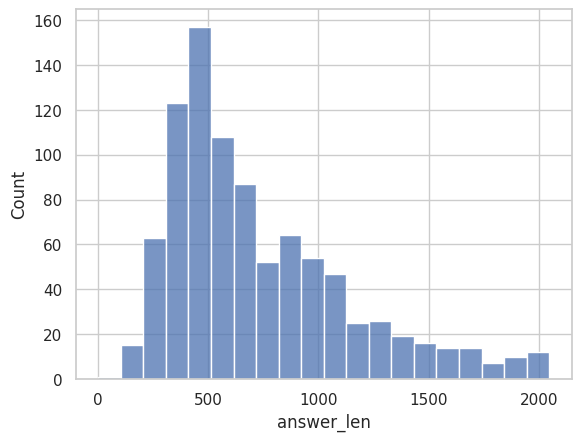

In [27]:
sns.histplot(sgg_df['answer_len'])


## Counting the frames for each video segment

In [19]:
sgg_df['stsg']


0      Here’s a scene graph representing the observed...
1      Okay, here’s a scene graph representing the vi...
2      Here’s a scene graph representation of the vid...
3      Here’s a scene graph representing the objects ...
4      Okay, here’s a scene graph representing the ev...
                             ...                        
909    Here’s a scene graph representing the events o...
910    Here’s a scene graph representing the observed...
911    Here’s a scene graph representation of the vid...
912    Here’s a scene graph representing the video, i...
913    Here’s a scene graph representing the events a...
Name: stsg, Length: 914, dtype: object

In [20]:
sggx_df = sgg_df[contains_stsg_mask].copy()

sggx_df['frames'] = sggx_df['stsg'].apply(lambda x: re.findall("([Ff]rame\s+\d+)", x))
sggx_df['n_frames'] = sggx_df['frames'].apply(len)
sggx_df['expected_frames'] = sggx_df[['start', 'end']].apply(lambda row: int(row['end'] - row['start']), axis=1)

(sggx_df['n_frames'] - sggx_df['expected_frames']).describe()


count    912.00000
mean       0.33443
std        2.75430
min      -17.00000
25%        0.00000
50%        0.00000
75%        1.00000
max       16.00000
dtype: float64

<Axes: xlabel='n_frames', ylabel='Count'>

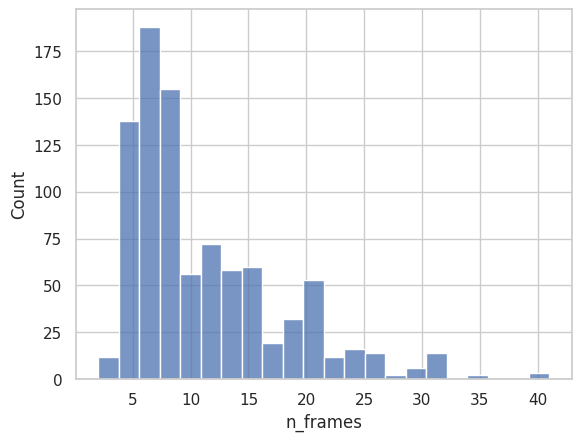

In [25]:
sns.histplot(sggx_df['n_frames'])


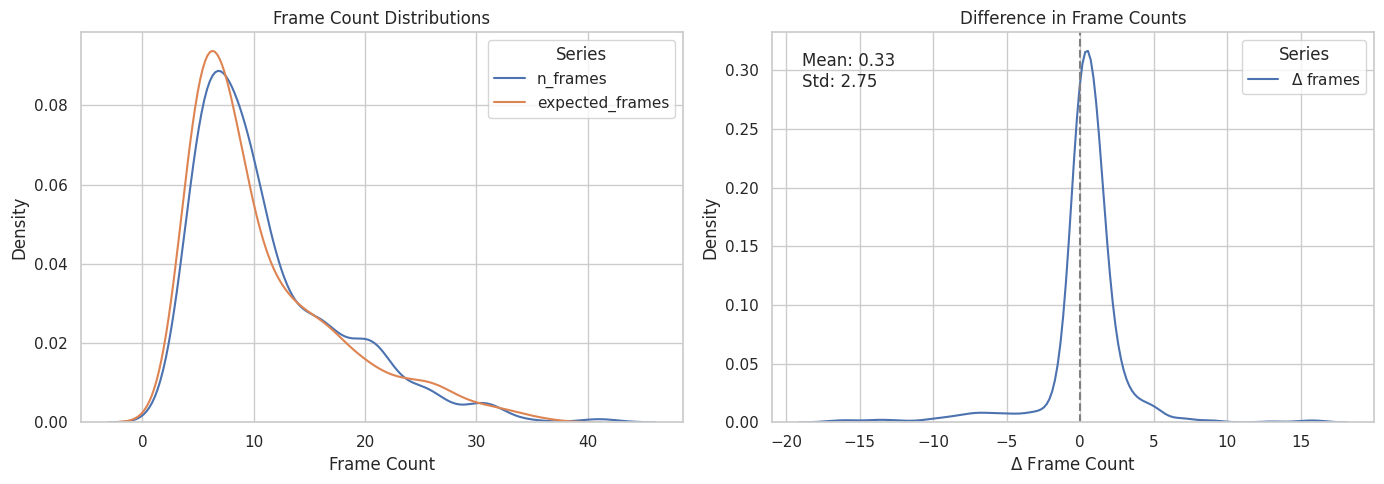

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frame count distributions
sns.kdeplot(
    sggx_df['n_frames'],
    ax=axes[0], label='n_frames')
sns.kdeplot(
    sggx_df['expected_frames'],
    ax=axes[0], label='expected_frames')
axes[0].set_title('Frame Count Distributions')
axes[0].set_xlabel('Frame Count')
axes[0].legend(title='Series')

# Difference distribution with stats
delta = sggx_df['n_frames'] - sggx_df['expected_frames']
sns.kdeplot(delta, ax=axes[1], label='$\\Delta$ frames')
axes[1].axvline(0, color='grey', linestyle='--')
mean = delta.mean()
std = delta.std()
stats = f"Mean: {mean:.2f}\nStd: {std:.2f}"
axes[1].text(0.05, 0.95, stats, transform=axes[1].transAxes, va='top')
axes[1].set_title('Difference in Frame Counts')
axes[1].set_xlabel('$\\Delta$ Frame Count')
axes[1].legend(title='Series')

plt.tight_layout()
plt.show()


In [22]:
from scipy import stats
d = sggx_df['n_frames'] - sggx_df['expected_frames']
stat, p = stats.ttest_1samp(d, 0)
print(f"t={stat:.3f}, p={p:.3f}")


t=3.667, p=0.000


We can see that the model behaves well in detecting the number of frames when given the text delimiter between images.